<a href="https://colab.research.google.com/github/Daesere/551Assignments/blob/main/551A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1: Data acquisition, preprocessing, and exploration

## 1.1 Loading the data

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving day.csv to day.csv
Saving hour.csv to hour.csv


In [ ]:
import pandas as pd
import io

day_df = pd.read_csv(io.BytesIO(uploaded['day.csv']))
hour_df = pd.read_csv(io.BytesIO(uploaded['hour.csv']))


In [ ]:
print(day_df.shape[0], day_df.shape[1], day_df.dtypes)

731 16 instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object


## 1.2 Data cleaning and preprocessing

In [ ]:
# Check for missing values (should be none according to dataset website)
check_nan_day = day_df.isnull().values.any()
check_nan_hour = hour_df.isnull().values.any()
print(check_nan_day, check_nan_hour)

False False


In [ ]:
# Drop IDs
day_df.drop('instant', axis=1, inplace=True)

# Drop casual and registered (cnt = casual + registered) to prevent data leakage
day_df.drop('casual', axis=1, inplace=True)
day_df.drop('registered', axis=1, inplace=True)

print(day_df)
hour_df.drop('instant', axis=1, inplace=True)

hour_df.drop('casual', axis=1, inplace=True)
hour_df.drop('registered', axis=1, inplace=True)

         dteday  season  yr  mnth  holiday  weekday  workingday  weathersit  \
0    2011-01-01       1   0     1        0        6           0           2   
1    2011-01-02       1   0     1        0        0           0           2   
2    2011-01-03       1   0     1        0        1           1           1   
3    2011-01-04       1   0     1        0        2           1           1   
4    2011-01-05       1   0     1        0        3           1           1   
..          ...     ...  ..   ...      ...      ...         ...         ...   
726  2012-12-27       1   1    12        0        4           1           2   
727  2012-12-28       1   1    12        0        5           1           2   
728  2012-12-29       1   1    12        0        6           0           2   
729  2012-12-30       1   1    12        0        0           0           1   
730  2012-12-31       1   1    12        0        1           1           2   

         temp     atemp       hum  windspeed   cnt 

In [ ]:
import numpy as np
# Encode categorical features as either one-hot or cyclical
day_df_cg = day_df.copy(deep=True) # Save copy for plots
# Perform sin/cosine transformations

def preprocess_bike_data(df, ohe=False):
    df_processed = df.copy()
    # Convert dte into day to be processed as an int
    df_processed['day'] = pd.to_datetime(df_processed['dteday']).dt.day
    df_processed.drop(columns=['dteday'], axis=1, inplace=True)

    # One hot encoding weathersit and season as they are not ordered (decided season wasn't ordered)
    if ohe:
      weather_encoded = pd.get_dummies(df['weathersit'], prefix='weather', drop_first=True, dtype=int)
      season_encoded = pd.get_dummies(df['season'], prefix='season', drop_first=True, dtype=int)
      df_processed.drop(columns=['weathersit', 'season'], axis=1, inplace=True)
      df_processed = pd.concat([df_processed, weather_encoded, season_encoded], axis=1)

    return df_processed


day_df_processed = preprocess_bike_data(day_df, ohe=True)
hour_df_processed = preprocess_bike_data(hour_df, ohe=True)
day_df_raw = preprocess_bike_data(day_df)
hour_df_raw = preprocess_bike_data(hour_df)
print(day_df_processed)

     yr  mnth  holiday  weekday  workingday      temp     atemp       hum  \
0     0     1        0        6           0  0.344167  0.363625  0.805833   
1     0     1        0        0           0  0.363478  0.353739  0.696087   
2     0     1        0        1           1  0.196364  0.189405  0.437273   
3     0     1        0        2           1  0.200000  0.212122  0.590435   
4     0     1        0        3           1  0.226957  0.229270  0.436957   
..   ..   ...      ...      ...         ...       ...       ...       ...   
726   1    12        0        4           1  0.254167  0.226642  0.652917   
727   1    12        0        5           1  0.253333  0.255046  0.590000   
728   1    12        0        6           0  0.253333  0.242400  0.752917   
729   1    12        0        0           0  0.255833  0.231700  0.483333   
730   1    12        0        1           1  0.215833  0.223487  0.577500   

     windspeed   cnt  day  weather_2  weather_3  season_2  season_3  season

## 1.3 Data visualization and exploratory analysis

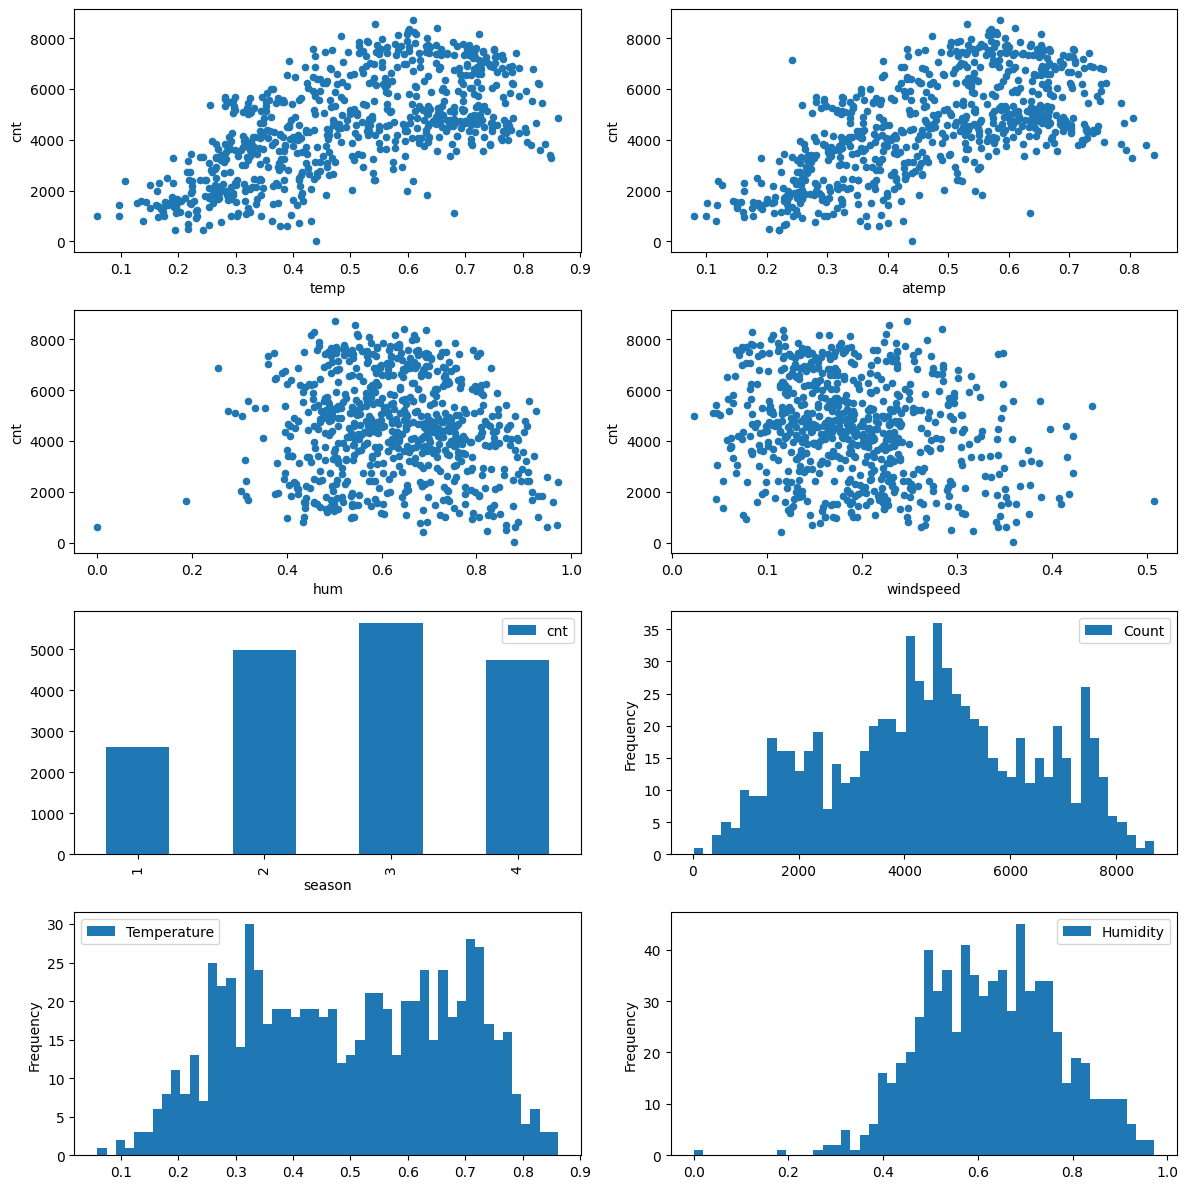

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(4, 2, figsize=(12, 12))

day_df.plot.scatter(x="temp", y="cnt", ax=axs[0, 0])
day_df.plot.scatter(x="atemp", y="cnt", ax=axs[0, 1])
day_df.plot.scatter(x="hum", y="cnt", ax=axs[1, 0])
day_df.plot.scatter(x="windspeed", y="cnt", ax=axs[1, 1])

day_df_cg.groupby("season", as_index=False)["cnt"].mean() \
    .plot.bar(x="season", y="cnt", ax=axs[2, 0])

day_df["cnt"].plot.hist(ax=axs[2, 1], bins=50, label="Count").legend()

day_df["temp"].plot.hist(ax=axs[3, 0], bins=50, label="Temperature").legend()

day_df["hum"].plot.hist(ax=axs[3, 1], bins=50, label="Humidity").legend()

plt.tight_layout()
plt.show()


# Task 2: Linear regression (analytic solution)

## 2.1 Model implementation

In [ ]:
import numpy as np
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
np.random.seed(1234)

In [ ]:
class LinearRegression:
  def __init__(self, add_bias=True):

    self.add_bias = add_bias
    return

  def fit(self, x, y):
    if x.ndim == 1:
        x = x[:, None]

    N = x.shape[0]

    if self.add_bias:
        x = np.column_stack([x, np.ones(N)])

    self.w = np.linalg.lstsq(x, y, rcond=None)[0]

    return self

  def predict(self, x):

    if self.add_bias:
      x = np.column_stack([x, np.ones(x.shape[0])])

    yh = x @ self.w

    return yh

  def MSE(self, y, yh):
    return np.mean((y - yh) ** 2)


In [ ]:
import copy
day_df_fe = copy.deepcopy(day_df)

from sklearn.preprocessing import StandardScaler

def feature_engineer(X, poly_indices=None, interaction_pairs=None, log_indices=None, sincos_indices=None):
    features = [X]

    # 1. Polynomials
    if poly_indices:
        for idx in poly_indices:
            features.append((X[:, idx] ** 2).reshape(-1, 1))

    # 2. Targeted Interactions
    if interaction_pairs:
        for idx1, idx2 in interaction_pairs:
            features.append((X[:, idx1] * X[:, idx2]).reshape(-1, 1))

    # 3. Log Transforms
    if log_indices:
        for idx in log_indices:
            features.append(np.log1p(X[:, idx]).reshape(-1, 1))

    # 4. Sin Cosine Transforms
    if sincos_indices:
      for idx, interval in sincos_indices:
        features.append(np.sin(2 * np.pi * X[:, idx] / interval))
        features.append(np.cos(2 * np.pi * X[:, idx] / interval))

    return np.column_stack(features)

In [ ]:
import random
from sklearn import model_selection

def test(df, name, x_labels='all', y_labels=['cnt'],
         poly_cols=['temp','atemp','hum','windspeed'], inter_pairs=[('temp', 'hum'), ('atemp', 'hum'), ('temp', 'wind')], log_cols=['windspeed','hum'], sincos_indices=[('month', 12),('weekday', 7), ('hr', 24)], seed=42):

    if x_labels == 'all':
        x_labels = [col for col in df.columns if col not in y_labels]

    x_raw = df[x_labels]
    y = df[y_labels].values

    # 1. Base Split (Maintains DataFrame structure for index mapping)
    x_train_df, x_test_df, y_train, y_test = model_selection.train_test_split(
        x_raw, y, test_size=0.2, random_state=seed
    )

    # Pre-calculate indices based on column names
    p_idx = [x_raw.columns.get_loc(c) for c in poly_cols if c in x_raw.columns]
    l_idx = [x_raw.columns.get_loc(c) for c in log_cols if c in x_raw.columns]
    i_idx = [(x_raw.columns.get_loc(c1), x_raw.columns.get_loc(c2))
             for c1, c2 in inter_pairs if c1 in x_raw.columns and c2 in x_raw.columns]
    sc_idx = [(x_raw.columns.get_loc(c1), c2)
             for c1, c2 in sincos_indices if c1 in x_raw.columns]
    results = []

    # Define the stages of FE
    stages = [
        ("Base", False, False, False, False),
        ("Poly", True, False, False, False),
        ("Poly+Sincos", True, False, False, True),
        ("Poly+Sincos+Inter", True, True, False, True),
        ("Poly+Sincos+Inter+Log", True, True, True, True)

    ]

    for stage_name, use_poly, use_inter, use_log, use_sincos in stages:
        # Filter indices based on stage requirements
        current_p = p_idx if use_poly else None
        current_i = i_idx if use_inter else None
        current_l = l_idx if use_log else None
        current_sc = sc_idx if use_sincos else None

        # Convert DFs to values only when passing to the engineer
        X_tr_eng = feature_engineer(x_train_df.values, current_p, current_i, current_l, current_sc)
        X_te_eng = feature_engineer(x_test_df.values, current_p, current_i, current_l, current_sc)
        model = LinearRegression()
        model.fit(X_tr_eng, y_train)

        train_mse = model.MSE(y_train, model.predict(X_tr_eng))
        test_mse = model.MSE(y_test, model.predict(X_te_eng))

        results.append({
            "Data Setup": name,
            "FE Stage": stage_name,
            "Train MSE": round(train_mse, 2),
            "Test MSE": round(test_mse, 2),
            "Gap (%)": round(((test_mse - train_mse) / train_mse) * 100, 1) if train_mse != 0 else 0
        })

    return results

def compare(count):
    all_results = []
    seeds = [random.randint(1, 100) for _ in range(count)]
    for s in seeds:
        all_results.extend(test(day_df_raw, "Raw day", seed=s))
        all_results.extend(test(day_df_processed, "One-hot day", seed=s))
        all_results.extend(test(hour_df_raw, "Raw hour", seed=s))
        all_results.extend(test(hour_df_processed, "One-hot hour", seed=s))
    summary = pd.DataFrame(all_results)

    pivot_summary = summary.groupby(['Data Setup', 'FE Stage'], sort=False)[['Train MSE', 'Test MSE']].mean()

    print(f"\n--- Averaged Results Across {count} Seeds ---")
    print(pivot_summary)

    return summary
summary = compare(100)


--- Averaged Results Across 100 Seeds ---
                                      Train MSE     Test MSE
Data Setup   FE Stage                                       
Raw day      Base                   734053.2755  818182.6491
             Poly                   528679.6138  589513.9481
             Poly+Sincos            527548.0357  592368.2596
             Poly+Sincos+Inter      525791.6579  594869.7146
             Poly+Sincos+Inter+Log  521478.2042  619000.2709
One-hot day  Base                   632687.9565  706621.5348
             Poly                   501926.5799  567547.2253
             Poly+Sincos            500454.8367  569963.4309
             Poly+Sincos+Inter      499352.2835  573995.8109
             Poly+Sincos+Inter+Log  495846.4003  581049.2566
Raw hour     Base                    20098.9096   20144.9541
             Poly                    19978.5629   20032.1055
             Poly+Sincos             16145.2941   16200.5421
             Poly+Sincos+Inter       16024

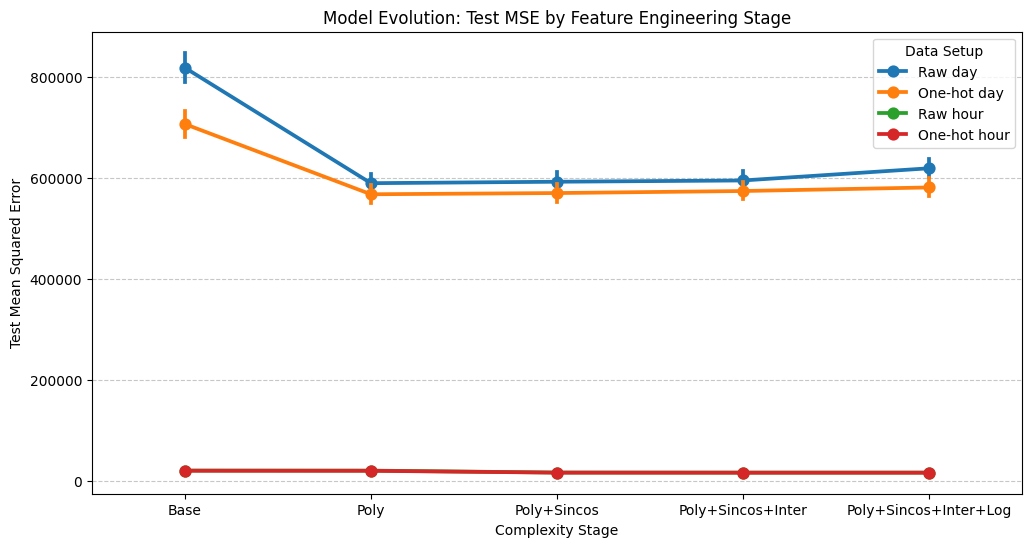

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_results(summary_df):
    plt.figure(figsize=(12, 6))

    # Lineplot to show the trend across FE stages
    sns.pointplot(data=summary_df, x='FE Stage', y='Test MSE', hue='Data Setup', markers="o", linestyles="-")

    plt.title('Model Evolution: Test MSE by Feature Engineering Stage')
    plt.ylabel('Test Mean Squared Error')
    plt.xlabel('Complexity Stage')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_results(summary)